<a href="https://colab.research.google.com/github/janewen134/sparse_rep_cnn/blob/main/sparse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from sklearn import linear_model

def KSVD(Y, dict_size,
         max_iter = 10,
         sparse_rate = 0.2,
         tolerance = 1e-6):
    
    assert(dict_size <= Y.shape[1])

    def dict_update(y, d, x):
        assert(d.shape[1] == x.shape[0])

        for i in range(x.shape[0]):
            index = np.where(np.abs(x[i, :]) > 1e-7)[0]

            if len(index) == 0:
                continue

            d[:, i] = 0
            r = (y - np.dot(d, x))[:, index]
            u, s, v = np.linalg.svd(r, full_matrices=False)
            d[:, i] = u[:, 0]
            for j,k in enumerate(index):
                x[i, k] = s[0] * v[0, j]
        return d, x


    # initialize dictionary
    if dict_size > Y.shape[0]:
        dic = Y[:, np.random.choice(Y.shape[1], dict_size, replace=False)]
    else:
        u, s, v = np.linalg.svd(Y)
        dic = u[:, :dict_size]
        
    print('dict shape:', dic.shape)
    
    n_nonzero_coefs_each_code = int(sparse_rate * dict_size) if int(sparse_rate * dict_size) > 0 else 1
    for i in range(max_iter):
        x = linear_model.orthogonal_mp(dic, Y, n_nonzero_coefs = n_nonzero_coefs_each_code)
        e = np.linalg.norm(Y - dic @ x)
        if e < tolerance:
            break
        dict_update(Y, dic, x)

    sparse_code = linear_model.orthogonal_mp(dic, Y, n_nonzero_coefs = n_nonzero_coefs_each_code)
    
    return dic, sparse_code



In [2]:
import numpy as np
import scipy.sparse as ss

# 生成随机稀疏矩阵 X
num_col_X = 30
num_row_X = 10
num_ele_X = 40
a = [np.random.randint(0,num_row_X) for _ in range(num_ele_X)]
b = [np.random.randint(0,num_col_X) for _ in range(num_ele_X - num_col_X)] + [i for i in range(num_col_X)]
c = [np.random.rand()*10 for _ in range(num_ele_X)]
rows, cols, v = np.array(a), np.array(b), np.array(c)
sparseX = ss.coo_matrix((v,(rows,cols)))
X = sparseX.todense()

# 随机生成字典 D
num_row_D = 10
num_col_D = num_row_X
D = np.random.random((num_row_D,num_col_D))

# 生成 Y
Y = D @ X

In [8]:
dic, code = KSVD(Y, 25)
Y_reconstruct = dic @ code



dict shape: (10, 25)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_omp.py:420: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  X, y[:, k], n_nonzero_coefs, tol, copy_X=copy_X, return_path=return_path
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validati

(None,)

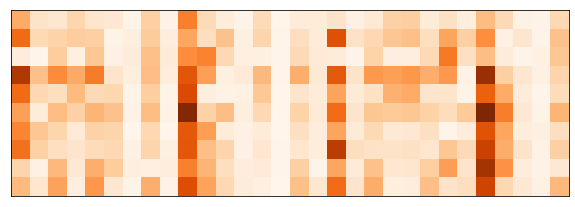

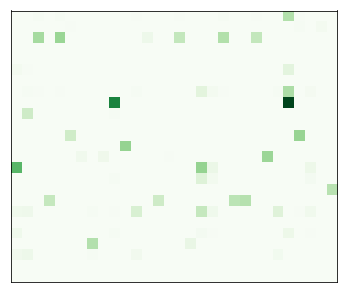

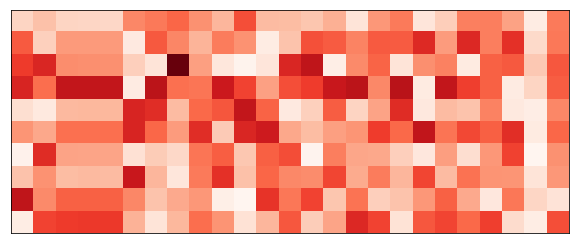

In [10]:
import matplotlib.pyplot as plt

def showmat(X, cmap='Oranges'):
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(111)
    X_abs = np.abs(X)
    ax.matshow(X_abs, vmin=np.min(X_abs), vmax=np.max(X_abs), cmap=cmap)
    ax.set_xticks([])
    ax.set_yticks([])

showmat(Y_reconstruct), 
# showmat(Y)
showmat(code,'Greens'), 
# showmat(X,'Greens')
showmat(dic,'Reds'), 
# showmat(D, 'Reds')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


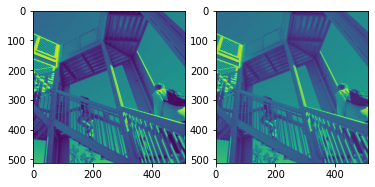

In [11]:
import numpy as np
from sklearn import linear_model
import scipy.misc
from matplotlib import pyplot as plt


class KSVD(object):
    def __init__(self, n_components, max_iter=30, tol=1e-6,
                 n_nonzero_coefs=None):
        """
        稀疏模型Y = DX，Y为样本矩阵，使用KSVD动态更新字典矩阵D和稀疏矩阵X
        :param n_components: 字典所含原子个数（字典的列数）
        :param max_iter: 最大迭代次数
        :param tol: 稀疏表示结果的容差
        :param n_nonzero_coefs: 稀疏度
        """
        self.dictionary = None
        self.sparsecode = None
        self.max_iter = max_iter
        self.tol = tol
        self.n_components = n_components
        self.n_nonzero_coefs = n_nonzero_coefs

    def _initialize(self, y):
        """
        初始化字典矩阵
        """
        u, s, v = np.linalg.svd(y)
        self.dictionary = u[:, :self.n_components]

    def _update_dict(self, y, d, x):
        """
        使用KSVD更新字典的过程
        """
        for i in range(self.n_components):
            index = np.nonzero(x[i, :])[0]
            if len(index) == 0:
                continue

            d[:, i] = 0
            r = (y - np.dot(d, x))[:, index]
            u, s, v = np.linalg.svd(r, full_matrices=False)
            d[:, i] = u[:, 0].T
            x[i, index] = s[0] * v[0, :]
        return d, x

    def fit(self, y):
        """
        KSVD迭代过程
        """
        self._initialize(y)
        for i in range(self.max_iter):
            x = linear_model.orthogonal_mp(self.dictionary, y, n_nonzero_coefs=self.n_nonzero_coefs)
            e = np.linalg.norm(y - np.dot(self.dictionary, x))
            if e < self.tol:
                break
            self._update_dict(y, self.dictionary, x)

        self.sparsecode = linear_model.orthogonal_mp(self.dictionary, y, n_nonzero_coefs=self.n_nonzero_coefs)
        return self.dictionary, self.sparsecode


if __name__ == '__main__':
    im_ascent = scipy.misc.ascent().astype(np.float)
    ksvd = KSVD(300)
    dictionary, sparsecode = ksvd.fit(im_ascent)
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(im_ascent)
    plt.subplot(1, 2, 2)
    plt.imshow(dictionary.dot(sparsecode))
    plt.show()